In [ ]:
# Продолжайте развитие и анализ сгененированных данных.
# 4.1. На выбор, реализация текстурных характеристик:
#  - Признаки Тамура
#  - матрица взаимной встречаемости
# 4.2. На выбор, реализация алгоритма сегментации при помощи выбранного алгоритма кластеризации данных:
# https://scikit-learn.ru/stable/modules/clustering.html
# 4.2.1 Если в кодировке пикселя не использовали его положение, выделите связные регионы.
# 4.3. На выбор, рассчитайте Качество проведенной сегментации на основе характеристик качества кластеризации:
# https://scikit-learn.ru/stable/modules/clustering.html#clustering-evaluation
# 4.4. Визуализируйте результат сегментации
# 4.5 Рассчитайте характеристики(описание формы) объектов.
# 4.6 Используя алгоритм кластеризации, найдите количество классов объектов на изображении.

In [1]:
!unzip /content/generated_data.zip -d /content/

Archive:  /content/generated_data.zip
   creating: /content/generated_data/
  inflating: /content/generated_data/clean_1772.png  
  inflating: /content/generated_data/clean_3062.png  
  inflating: /content/generated_data/clean_3217.png  
  inflating: /content/generated_data/clean_4093.png  
  inflating: /content/generated_data/clean_4282.png  
  inflating: /content/generated_data/clean_4972.png  
  inflating: /content/generated_data/clean_6253.png  
  inflating: /content/generated_data/clean_6558.png  
  inflating: /content/generated_data/clean_7667.png  
  inflating: /content/generated_data/clean_7903.png  
  inflating: /content/generated_data/clean_8031.png  
  inflating: /content/generated_data/clean_8249.png  


Выбрано изображение: clean_3062.png


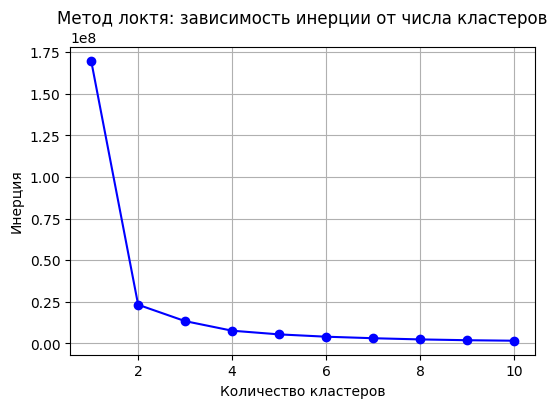

Силуэтный коэффициент: 0.59
Индекс Калинского-Харабаша: 9019.59


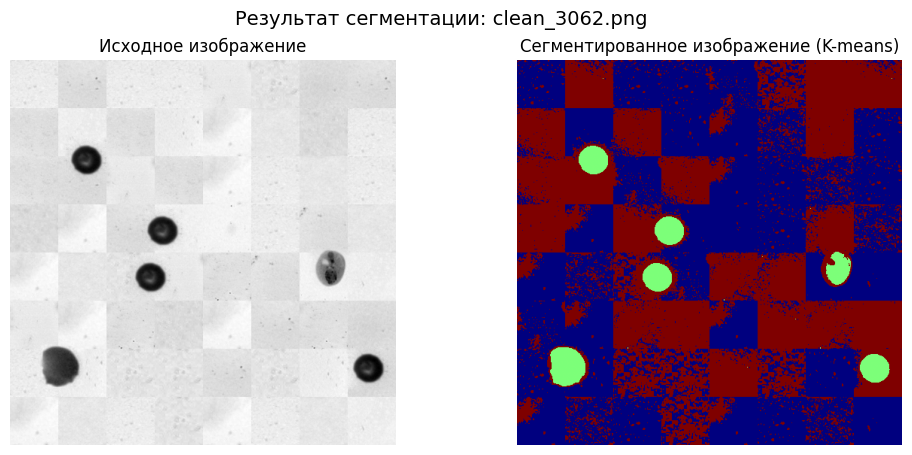

Признаки Тамура: Контраст=25.45, Крупность=109.46, Направленность=0.07
Количество связных регионов: 1960


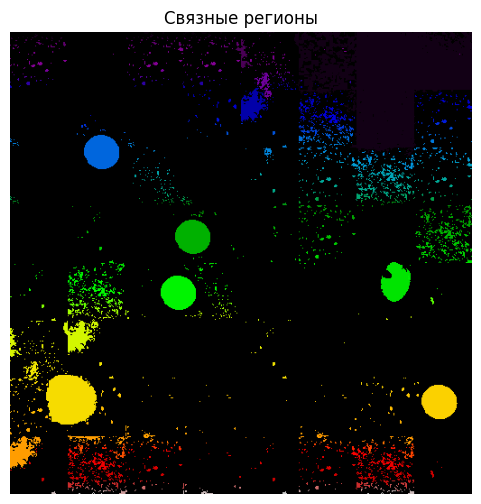

In [13]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from skimage import measure
from skimage.measure import regionprops

# 1. Загрузка случайного изображения из папки
def load_random_image(folder_path):
    files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.bmp'))]
    random_file = random.choice(files)
    img_path = os.path.join(folder_path, random_file)
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    return image, random_file  # Вернем также имя файла

# 2. Метод локтя (Elbow Method)
def plot_elbow_method(image, max_clusters=10):
    pixels = image.reshape(-1, 1)  # Преобразуем в список пикселей
    inertia_values = []  # Храним значения инерции
    cluster_range = range(1, max_clusters + 1)

    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(pixels)
        inertia_values.append(kmeans.inertia_)

    # Строим график
    plt.figure(figsize=(6, 4))
    plt.plot(cluster_range, inertia_values, marker='o', linestyle='-', color='b')
    plt.xlabel("Количество кластеров")
    plt.ylabel("Инерция")
    plt.title("Метод локтя: зависимость инерции от числа кластеров")
    plt.grid()
    plt.show()

    # Найдем оптимальное количество кластеров (точка "излома")
    optimal_k = 3  # Можно выбрать вручную по графику
    return optimal_k

# 3. K-means сегментация
def kmeans_segmentation(image, n_clusters):
    pixels = image.reshape(-1, 1)  # Преобразуем в список пикселей
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    segmented = labels.reshape(image.shape)
    return segmented

# 4. Оценка кластеризации (ускоренная версия)
def evaluate_clustering(image, segmented, sample_size=1000):
    pixels = image.reshape(-1, 1)
    labels = segmented.reshape(-1)

    if len(pixels) > sample_size:
        sample_idxs = random.sample(range(len(pixels)), sample_size)
        pixels = pixels[sample_idxs]
        labels = labels[sample_idxs]

    silhouette = silhouette_score(pixels, labels)
    calinski_harabasz = calinski_harabasz_score(pixels, labels)
    return silhouette, calinski_harabasz

# 5. Визуализация результата сегментации
def visualize_segmentation(image, segmented, filename):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title("Исходное изображение")

    plt.subplot(1, 2, 2)
    plt.imshow(segmented, cmap="jet")
    plt.axis("off")
    plt.title("Сегментированное изображение (K-means)")

    plt.suptitle(f"Результат сегментации: {filename}", fontsize=14)
    plt.show()

# 6. Признаки Тамура (упрощенная реализация)
def tamura_features(image):
    # Контраст
    contrast = np.std(image)

    # Крупность (coarseness)
    # Реализуем упрощенный расчет крупности через разницу соседних пикселей
    diff = np.abs(image[:-1, :-1] - image[1:, 1:])
    coarseness = np.mean(diff)

    # Направленность (directionality)
    # Реализуем упрощенный расчет направленности через градиенты
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    directionality = np.mean(np.arctan2(grad_y, grad_x))

    return contrast, coarseness, directionality

# 7. Выделение связных регионов
def connected_regions(segmented):
    labeled_image = measure.label(segmented)
    regions = regionprops(labeled_image)
    return labeled_image, regions

# 8. Характеристики формы объектов
def shape_features(regions):
    features = []
    for region in regions:
        area = region.area
        perimeter = region.perimeter
        eccentricity = region.eccentricity
        features.append((area, perimeter, eccentricity))
    return features

# 9. Основная функция обработки изображения
def process_image(folder_path):
    image, filename = load_random_image(folder_path)
    print(f"Выбрано изображение: {filename}")

    # Метод локтя для определения числа кластеров
    optimal_k = plot_elbow_method(image)

    # Запуск K-means с оптимальным числом кластеров
    segmented = kmeans_segmentation(image, optimal_k)

    # Оценка качества кластеризации
    silhouette, calinski_harabasz = evaluate_clustering(image, segmented)
    print(f"Силуэтный коэффициент: {silhouette:.2f}")
    print(f"Индекс Калинского-Харабаша: {calinski_harabasz:.2f}")

    # Визуализация сегментации
    visualize_segmentation(image, segmented, filename)

    # Признаки Тамура
    contrast, coarseness, directionality = tamura_features(image)
    print(f"Признаки Тамура: Контраст={contrast:.2f}, Крупность={coarseness:.2f}, Направленность={directionality:.2f}")

    # Выделение связных регионов
    labeled_image, regions = connected_regions(segmented)
    print(f"Количество связных регионов: {len(regions)}")

    # Характеристики формы объектов
    shape_feats = shape_features(regions)
    #for i, (area, perimeter, eccentricity) in enumerate(shape_feats):
     #   print(f"Объект {i+1}: Площадь={area}, Периметр={perimeter:.2f}, Эксцентриситет={eccentricity:.2f}")

    # Визуализация связных регионов
    plt.figure(figsize=(6, 6))
    plt.imshow(labeled_image, cmap="nipy_spectral")
    plt.axis("off")
    plt.title("Связные регионы")
    plt.show()

# Запуск обработки случайного изображения из папки
process_image("/content/generated_data")